In [1]:
import joblib
import json 
import requests

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

import xgboost as xgb

from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

In [2]:
# Read in the data
data = pd.read_csv('turbine-data.csv')

# The unnamed column seems to be dates. Convert column to datetime and set as index
data = data.rename(columns={'Unnamed: 0': 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Print out last five rows
data.tail()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,1029.870744,...,58.148777,39.008931,36.476562,178.0,13.775785,9.234004,2.0,G01,178.0,3.533445
2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,1030.160478,...,57.550367,39.006759,36.328125,178.0,8.088928,9.229370,2.0,G01,178.0,3.261231
2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,1030.137822,...,57.099335,39.003815,36.131944,178.0,4.355978,9.236802,2.0,G01,178.0,3.331839
2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,1030.178178,...,56.847239,39.003815,36.007805,190.0,12.018077,9.237374,2.0,G01,190.0,3.284468
2020-03-30 23:50:00+00:00,68.664425,27.915828,45.231610,1.499323,1.933124,1.933124,0.0,58.581716,54.080505,1029.834789,...,56.741040,39.003815,35.914062,203.0,14.439669,9.235532,2.0,G01,203.0,3.475205


In [3]:
# Shift the values of the power 
# Predicted value if for 10 Minutes in the future
data['ActivePower'] = data.ActivePower.shift(-1)
data.tail(10)

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30 22:20:00+00:00,147.223697,27.583998,46.363847,0.682622,1.115857,1.115857,0.0,62.243332,56.684490,1030.098267,...,61.174030,39.982463,37.375000,188.000000,28.709709,9.234751,2.0,G01,188.000000,3.954384
2020-03-30 22:30:00+00:00,117.706939,27.577234,46.223171,0.633278,1.067585,1.067585,0.0,62.154613,56.514011,1030.347656,...,60.651139,39.733410,37.210633,188.000000,29.910468,9.230950,2.0,G01,188.000000,4.190217
2020-03-30 22:40:00+00:00,99.670237,27.508489,46.088975,1.023465,1.456349,1.456349,0.0,61.789414,56.285359,1029.891333,...,60.123138,39.024528,37.034593,184.666667,22.846505,9.233694,2.0,G01,184.666667,3.949295
2020-03-30 22:50:00+00:00,90.331065,27.440426,45.941079,1.237270,1.671673,1.671673,0.0,60.797234,55.886593,1029.654240,...,59.359762,39.035784,36.846869,178.000000,20.129394,9.234792,2.0,G01,178.000000,3.920965
2020-03-30 23:00:00+00:00,70.044465,27.581193,45.819084,1.411808,1.846226,1.846226,0.0,60.275851,55.552022,1029.805433,...,58.729390,39.010394,36.650659,178.000000,17.792888,9.235228,2.0,G01,178.000000,3.612339
2020-03-30 23:10:00+00:00,40.833474,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,1029.870744,...,58.148777,39.008931,36.476562,178.000000,13.775785,9.234004,2.0,G01,178.000000,3.533445
2020-03-30 23:20:00+00:00,20.777790,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,1030.160478,...,57.550367,39.006759,36.328125,178.000000,8.088928,9.229370,2.0,G01,178.000000,3.261231
2020-03-30 23:30:00+00:00,62.091039,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,1030.137822,...,57.099335,39.003815,36.131944,178.000000,4.355978,9.236802,2.0,G01,178.000000,3.331839
2020-03-30 23:40:00+00:00,68.664425,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,1030.178178,...,56.847239,39.003815,36.007805,190.000000,12.018077,9.237374,2.0,G01,190.000000,3.284468


In [4]:
# Fill missing values using ffull and bfill and 
# confirm that we don't have any null values left in the dataset
data = data.fillna(method='ffill').fillna(method='bfill')
#data.isnull().sum()

In [29]:
data.info()

AttributeError: 'dict' object has no attribute 'info'

Text(0, 0.5, 'Power generated')

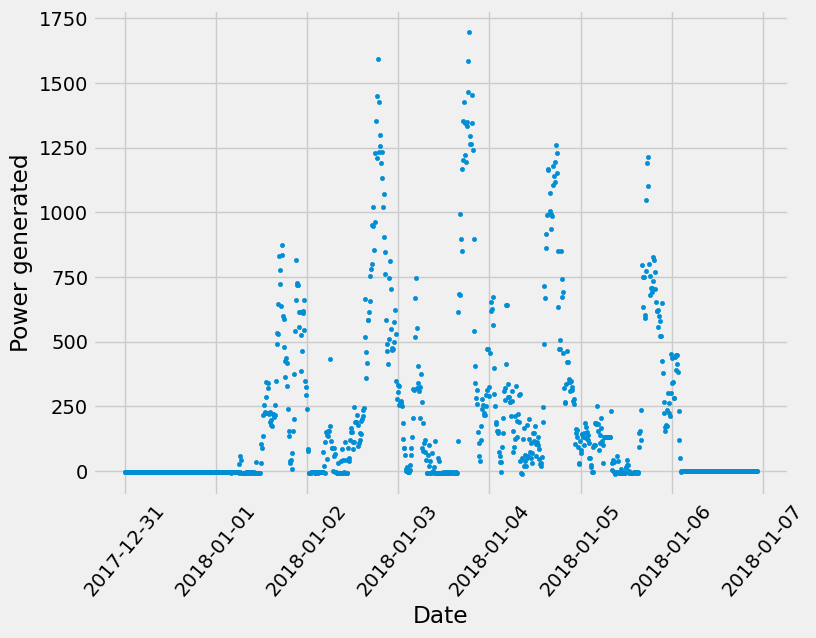

In [6]:
# Use tivethirtyeight as a sytle because it looks really nice
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))

# Plot the first 1000 datapoints of power generated
plt.scatter(data.index[:1000], data['ActivePower'][:1000], marker='.')

# Set labels and rotate x labels for better readabilty
plt.xlabel('Date')
plt.xticks(rotation=50)
plt.ylabel('Power generated')

Text(0, 0.5, 'Wind speed')

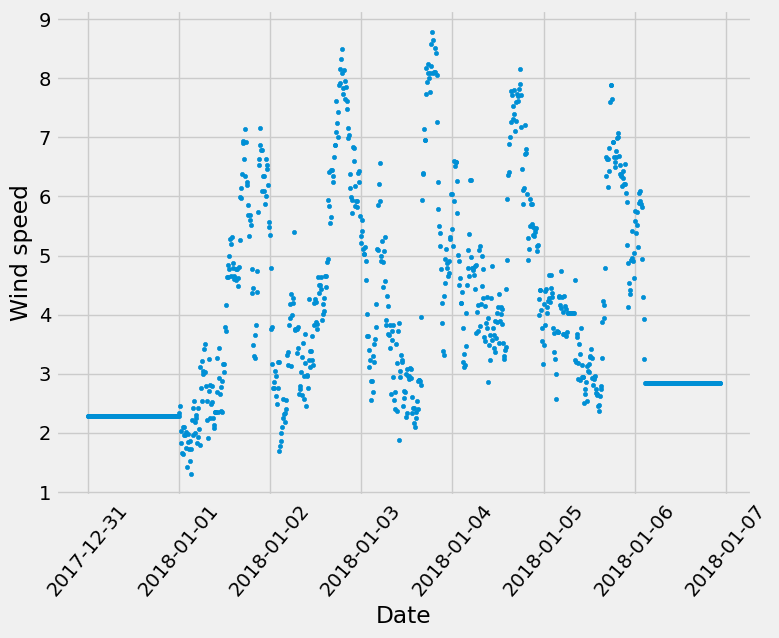

In [7]:
# Do the same as above, but with wind speed
plt.figure(figsize=(8, 6))

# Plot the first 1000 datapoints of wind speed 
plt.scatter(data.index[:1000], data['WindSpeed'][:1000], marker='.')

# Set labels and rotate x labels for better readabilty
plt.xlabel('Date')
plt.xticks(rotation=50)
plt.ylabel('Wind speed')

Text(0, 0.5, 'Number of days')

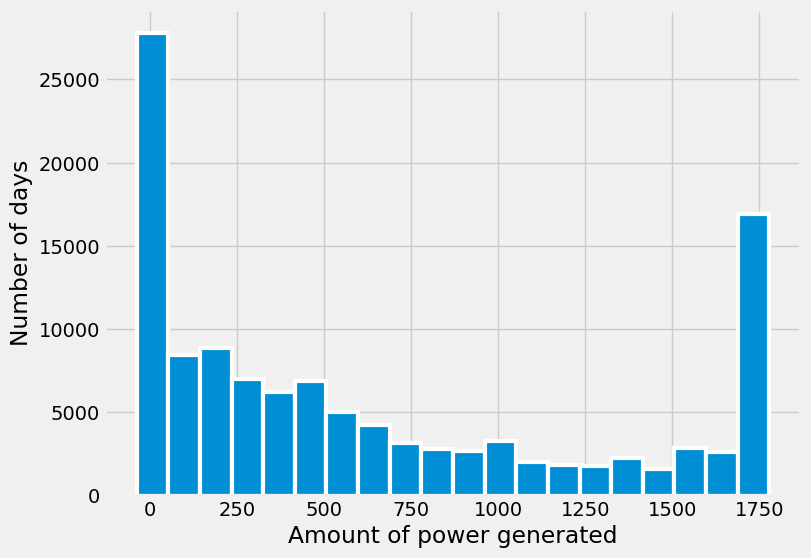

In [8]:
plt.figure(figsize=(8, 6))

# Plot the generated power in a histogram to get a feel of much much energy was usually generated
data.ActivePower.plot(kind='hist', linewidth=3, edgecolor='white', bins=20)

# Set labels
plt.xlabel('Amount of power generated')
plt.ylabel('Number of days')

In [9]:
# The columns WTG is only a single value, so it might be dropped
data.WTG.value_counts()

G01    118224
Name: WTG, dtype: int64

In [10]:
# Split up data into X (features) any y (targets)
X = data.drop(['ActivePower','ControlBoxTemperature', 'WTG'], axis=1)
y = data.ActivePower.values

In [11]:
# Train-test-split for later evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Define hyperparamter space
dt_space = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'max_features': hp.choice('max_features', range(1, 100)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 5)),
    'min_weight_fraction_leaf': hp.choice('min_weight_fraction_leaf', np.linspace(0, 0.5, num=10))
    }

# Objective function
def dt_objective(params):
    # Instantiate model
    dt = DecisionTreeRegressor(**params)

    # Fit and predict
    dt.fit(X_train, y_train)
    y_hat = dt.predict(X_test)
    
    # Calculate the root mean squared error
    rmse = mean_squared_error(y_test, y_hat, squared=False)
    print ("SCORE:", rmse)

    # Retrun loss, status and model
    return {'loss': rmse, 'status': STATUS_OK, 'model': dt}

# Trials to track progress
bayes_trials = Trials()

# Use the space and objective above to find best parameters
dt_best = fmin(fn=dt_objective, space=dt_space, algo=tpe.suggest, max_evals=28, trials=bayes_trials)

SCORE:                                                
207.5672505095551                                     
SCORE:                                                                         
268.58079515040777                                                             
SCORE:                                                                         
275.0681585388466                                                              
SCORE:                                                                         
361.4523522897245                                                              
SCORE:                                                                         
268.58079515040777                                                             
SCORE:                                                                         
275.0681585388466                                                              
SCORE:                                                                         
207.567250

In [19]:
# Print the values of the best parameters
dt_params = space_eval(dt_space, dt_best)
print(dt_params)

{'max_depth': 13, 'max_features': 13, 'min_samples_leaf': 3, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0}


In [20]:
dtr = DecisionTreeRegressor(**dt_params)
dtr.fit(X_train, y_train)

y_hat = dtr.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_hat)))

147.9349525709251


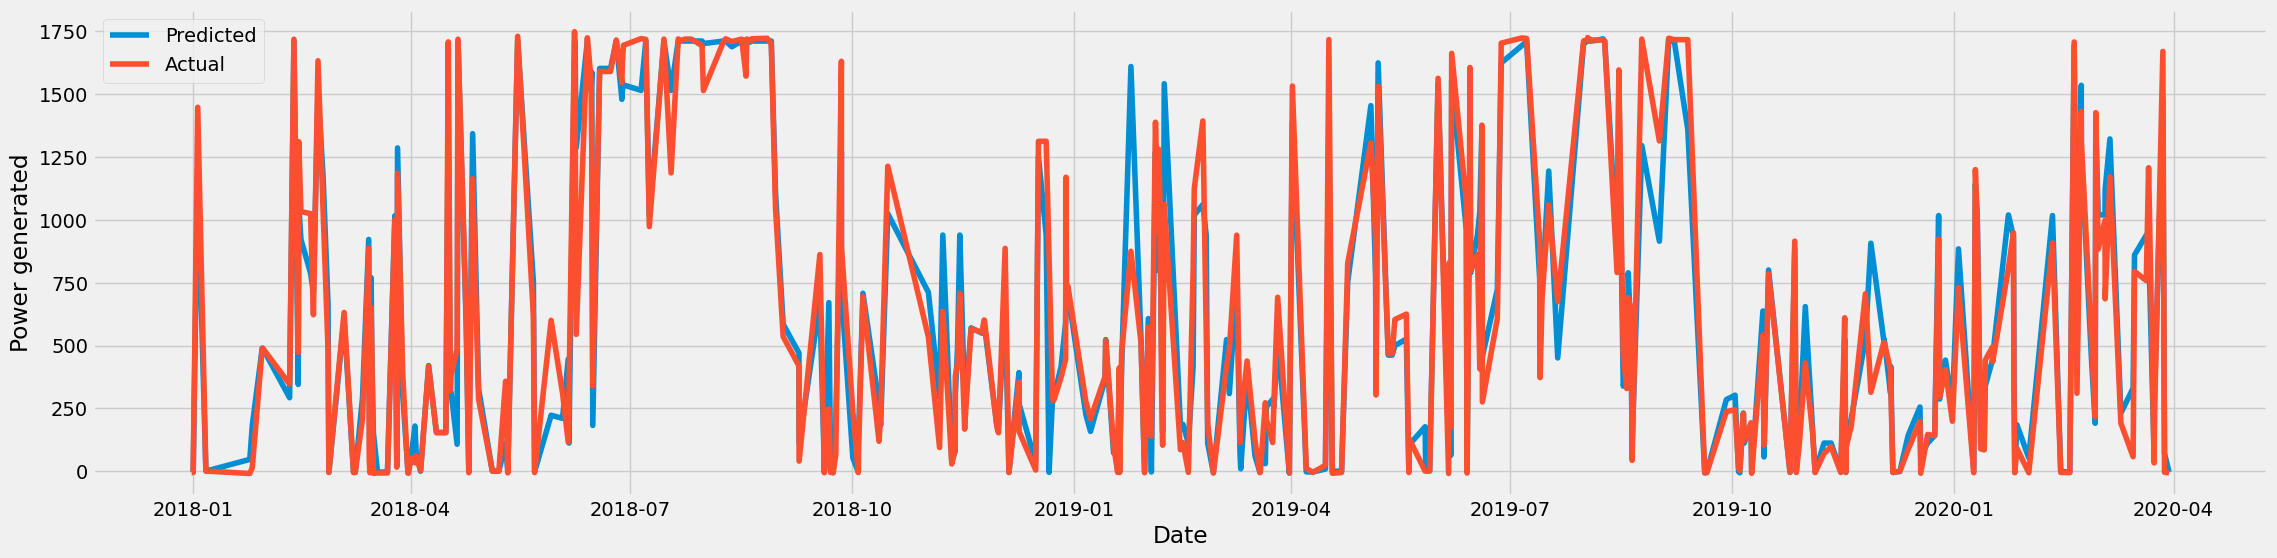

In [21]:
plt.figure(figsize=(25, 6))

# Plot the predicted and the acutal values on a line plot to see how well our model performed
sns.lineplot(x=X_test.index[:360], y=y_hat[:360], alpha=1, label='Predicted')
sns.lineplot(x=X_test.index[:360], y=y_test[:360], alpha=1, label='Actual')

# Labels and legend
plt.xlabel('Date')
plt.ylabel('Power generated')
plt.legend()
plt.show()

In [22]:
joblib.dump(dtr, 'windpred_model.pkl')

['windpred_model.pkl']

In [26]:
# Take a subset of our test data and save it so JSON format
entry = X_test.head(5)
entry.to_json('data.json')

# Load the JSON data
with open('data.json') as f:
    json_data = json.load(f)

In [28]:
# Send request to our serverless function
URL = 'https://windyfunction.azurewebsites.net/api/WindForecasting?code=Tr3jR7iBgZCfuQnO9eF4p6yIPENfacgAkfRMcj1sacS0AzFuTFHHzw=='
headers = {'Content-type': 'application/json'}
req = requests.post(URL, json=json.dumps(json_data))
print(req.text)

[
  {
    "energy_production": 230.78735064154228
  },
  {
    "energy_production": 88.20743451684292
  },
  {
    "energy_production": -0.44728666191384386
  },
  {
    "energy_production": -0.44728666191384386
  },
  {
    "energy_production": 932.3921582469286
  }
]
